# PREDICTION OF CHESS PIECE IMAGE CLASSES

The main steps are: 
* An Image Dataloader to load the image data and labels from folders
* Train-test-sample data splits
* A Classifier Network to identify important features and make prediction
* Application of appropriate metrics and scoring for evaluation

### Import Necessary Modules

In [1]:
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import PIL
import os
import re
import shutil
import random
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

### Transform object for conversion to tensor type and image normalization

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

### Dataloader Preparation and Train Test Validation Split

In [3]:
dataset = datasets.ImageFolder('dataset', transform=transform)

In [4]:
#GPU Batch Size of 32 used, and random seeds prepared for consistency among splitting & training processes

# Start revision
validation_split = .1
test_split = .1
# End revision

batch_size = 32
seed_val = 1903
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [5]:
#Random shuffling indices before split to get similar distribution among classes
#Image loading & training takes time, so we use part of the dataset (52.000 values)

dataset_size = len(dataset) 
indices = list(range(dataset_size))
np.random.shuffle(indices)

# Start Revision
# indices = indices[:75000] 
# End Revision

dataset_size_sm = len(indices)

In [6]:
split_test = int(np.floor(test_split * dataset_size_sm))
split_val = int(np.floor(validation_split * (dataset_size_sm-split_test)))+split_test

In [7]:
split_test, split_val, dataset_size_sm

(15168, 28819, 151680)

In [8]:
#Create Train-Test-Validation Datasets
train_indices, val_indices, test_indices = indices[split_val:], indices[split_test:split_val], indices[:split_test]

In [9]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, drop_last=True)

In [10]:
32 * (len(train_dataloader) + len(val_dataloader) + len(test_dataloader))

151648

In [11]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Start Revision
        # Convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 10, 5, padding=0)
        self.bn1 = nn.BatchNorm2d(10)
        # Convolutional layer (sees 110x110x10 tensor)
        self.conv2 = nn.Conv2d(10, 20, 5, padding=1)
        self.bn2 = nn.BatchNorm2d(20)
        # Convolutional layer (sees 54x54x20 tensor)
        self.conv3 = nn.Conv2d(20, 32, 3, padding=2)
        self.bn3 = nn.BatchNorm2d(32)
        # Convolutional layer (sees 28x28x32 tensor)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=2)
        self.bn4 = nn.BatchNorm2d(64)
        # Additional convolutional layer (sees 14x14x64 tensor)
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        # New convolutional layer (sees 7x7x128 tensor)
        self.conv6 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Linear layer (256 * 3 * 3 -> 500)
        self.fc1 = nn.Linear(256 * 3 * 3, 500)
        # Linear layer (500 -> 5)
        self.fc2 = nn.Linear(500, 6)
        # End Revision

        # Dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        
        # Start Revision
        # LeakyReLU activation
        self.relu = nn.LeakyReLU(0.01)
        # End Revision

    def forward(self, x):

        # Start Revision
        # Convolutional and max pooling layers
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        x = self.relu(self.bn6(self.conv6(x)))  # Apply conv6 without pooling
        x = self.pool(x)  # Apply the final pooling after the new conv layer

        # Flattening of result for fully connected (linear) layers
        x = x.view(-1, 256 * 3 * 3)
        # End Revision
        
        # Dropout
        x = self.dropout(x)
        # 1st fully connected layer
        x = self.relu(self.fc1(x))
        # Dropout
        x = self.dropout(x)
        # 2nd fully connected layer
        x = self.fc2(x)
        return x

#Create and print the model
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): M

### Loss Function, Optimizer and Network Training

* Adam Optimizer is used with 0.001 Learning Rate (weight decay, warmup not applied)
* nn.CrossEntropyLoss used as loss function, (applied after Softmax activation of network output)
* Model trained for 5 epochs and model with the minimum loss value is saved (training loop from pytorch training)

In [12]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [14]:
# number of epochs to train the model
n_epochs = 5

device = 'cuda'
model.to(device)

t0 = time.time()

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    train_accuracy = 0.0
    valid_accuracy = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    i=0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate batch accuracy
        probs = nn.functional.softmax(output, dim=1)
        preds = torch.argmax(probs, axis=1)
        accuracy = (abs(preds-labels)==0).type(torch.float).mean()
        # calculate the batch loss
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss & accuracy
        train_loss += loss.item()*images.size(0)
        train_accuracy += accuracy*images.size(0)
        
        #inform user about elapsed time in every 320 batches (320x32=10240 images)
        i += 1
        if i % 320 == 0:
            t1 = time.time()
            print(f'{i*images.shape[0]} items processed in {format_time(t1-t0)}')

        
    ######################    
    # Validate the model #
    ######################
    model.eval()
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate batch accuracy
        probs = nn.functional.softmax(output, dim=1)
        preds = torch.argmax(probs, axis=1)
        accuracy = (abs(preds-labels)==0).type(torch.float).mean()
        # calculate the batch loss
        loss = criterion(output, labels)
        # update average validation loss & accuracy
        valid_loss += loss.item()*images.size(0)
        valid_accuracy += accuracy*images.size(0)
    
    # calculate average losses & accuracies
    train_loss = train_loss/len(train_dataloader.sampler)
    valid_loss = valid_loss/len(val_dataloader.sampler)
    train_accuracy = train_accuracy/len(train_dataloader.sampler)
    valid_accuracy = valid_accuracy/len(val_dataloader.sampler)
        
    # print training/testation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    print('Epoch: {} \tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_accuracy, valid_accuracy))
    
    # save model if testation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_chess.pt')
        valid_loss_min = valid_loss

10240 items processed in 0:02:41
20480 items processed in 0:05:40
30720 items processed in 0:08:47
40960 items processed in 0:12:15
51200 items processed in 0:15:39
61440 items processed in 0:19:04
71680 items processed in 0:22:25
81920 items processed in 0:25:51
92160 items processed in 0:29:13
102400 items processed in 0:32:36
112640 items processed in 0:35:56
Epoch: 1 	Training Loss: 1.352303 	Validation Loss: 0.837761
Epoch: 1 	Training Accuracy: 0.445422 	Validation Accuracy: 0.669328
Validation loss decreased (inf --> 0.837761).  Saving model ...
10240 items processed in 0:45:46
20480 items processed in 0:48:10
30720 items processed in 0:50:50
40960 items processed in 0:53:21
51200 items processed in 0:55:46
61440 items processed in 0:58:14
71680 items processed in 1:00:43
81920 items processed in 1:03:06
92160 items processed in 1:05:57
102400 items processed in 1:08:51
112640 items processed in 1:11:46
Epoch: 2 	Training Loss: 0.667716 	Validation Loss: 0.475157
Epoch: 2 	Train

# Testing and Evaluation

* Trained Network is run through test dataset
* F1 Score calculated alongside accuracy and classification report is prepared since class distribution is imbalanced
* A confusion matrix to see class based predicted/actual class counts

In [15]:
#Get the minimum loss model
model = Net()
model.load_state_dict(torch.load('model_chess.pt'))

<All keys matched successfully>

In [16]:
device = 'cuda'
model.to(device)

# keep track of training and testing loss
test_loss = 0.0
test_accuracy = 0.0

predictions = []
true_labels = []

######################    
# test the model #
######################
model.eval()
for data, target in test_dataloader:
    images, labels = images.to(device), labels.to(device)
    # forward pass: compute predicted outputs(probabilities) by passing inputs to the model
    output = model(images)
    # get predictions with softmax activation and calculate batch accuracy
    probs = nn.functional.softmax(output, dim=1)
    preds = torch.argmax(probs, axis=1)
    accuracy = (abs(preds-labels)==0).type(torch.float).mean()
    # save predictions & labels
    predictions.extend(preds)
    true_labels.extend(labels)
    # calculate the batch loss
    loss = criterion(output, labels)
    # update average test loss & accuracy
    test_loss += loss.item()*images.size(0)
    test_accuracy += accuracy*images.size(0)

# calculate average losses & accuracies
test_loss = test_loss/len(test_dataloader.sampler)
test_accuracy = test_accuracy/len(test_dataloader.sampler)

# print test statistics 
print('Test Loss: {:.6f}'.format(test_loss))
print('\nTest Accuracy: {:.6f}'.format(test_accuracy))

Test Loss: 0.235261

Test Accuracy: 0.906250


In [23]:
#Method to calculate acurracy, f1, create a classification report and confusion matrix
def classification_score(y_test, y_pred, labels, target_names):
    f1 = f1_score(y_test, y_pred, average='micro')
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy Score = {accuracy}\nF1 Score:{f1}\n')
    
    # Start Revision
    print(classification_report(y_test, y_pred, labels=list(range(6)), target_names=['bishop', 'king', 'knight', 'pawn', 'queen', 'rook']))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred)[::-1,::-1], columns=['pred_bishop', 'pred_king', 'pred_knight', 'pred_pawn', 'pred_queen', 'pred_rook'][::-1], index=['bishop', 'king', 'knight', 'pawn', 'queen', 'rook'][::-1]))
    # End Revision

In [24]:
true_labels = [l.cpu() for l in true_labels]
predictions = [prediction.cpu() for prediction in predictions]

In [25]:
classification_score(true_labels, predictions, labels=list(range(5)), target_names=['bishop', 'king', 'knight', 'pawn', 'queen', 'rook'])

Accuracy Score = 0.90625
F1 Score:0.90625

              precision    recall  f1-score   support

      bishop       1.00      0.75      0.86      1896
        king       1.00      0.83      0.91      2844
      knight       0.79      1.00      0.88      5214
        pawn       1.00      1.00      1.00       948
       queen       1.00      1.00      1.00      1896
        rook       1.00      0.80      0.89      2370

    accuracy                           0.91     15168
   macro avg       0.96      0.90      0.92     15168
weighted avg       0.93      0.91      0.91     15168

        pred_rook  pred_queen  pred_pawn  pred_knight  pred_king  pred_bishop
rook         1896           0          0          474          0            0
queen           0        1896          0            0          0            0
pawn            0           0        948            0          0            0
knight          0           0          0         5214          0            0
king            0       

### Display images and predictions for the last batch(32)

In [26]:
#images, labels and predictions of last batch
len(images), len(labels), len(preds)

(32, 32, 32)

In [27]:
#Method to unnormalize, transpose and display images with predicted and actual labels
def imshow(img, name, preds):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(f'{name} - pred {preds}')
    plt.axis('off')

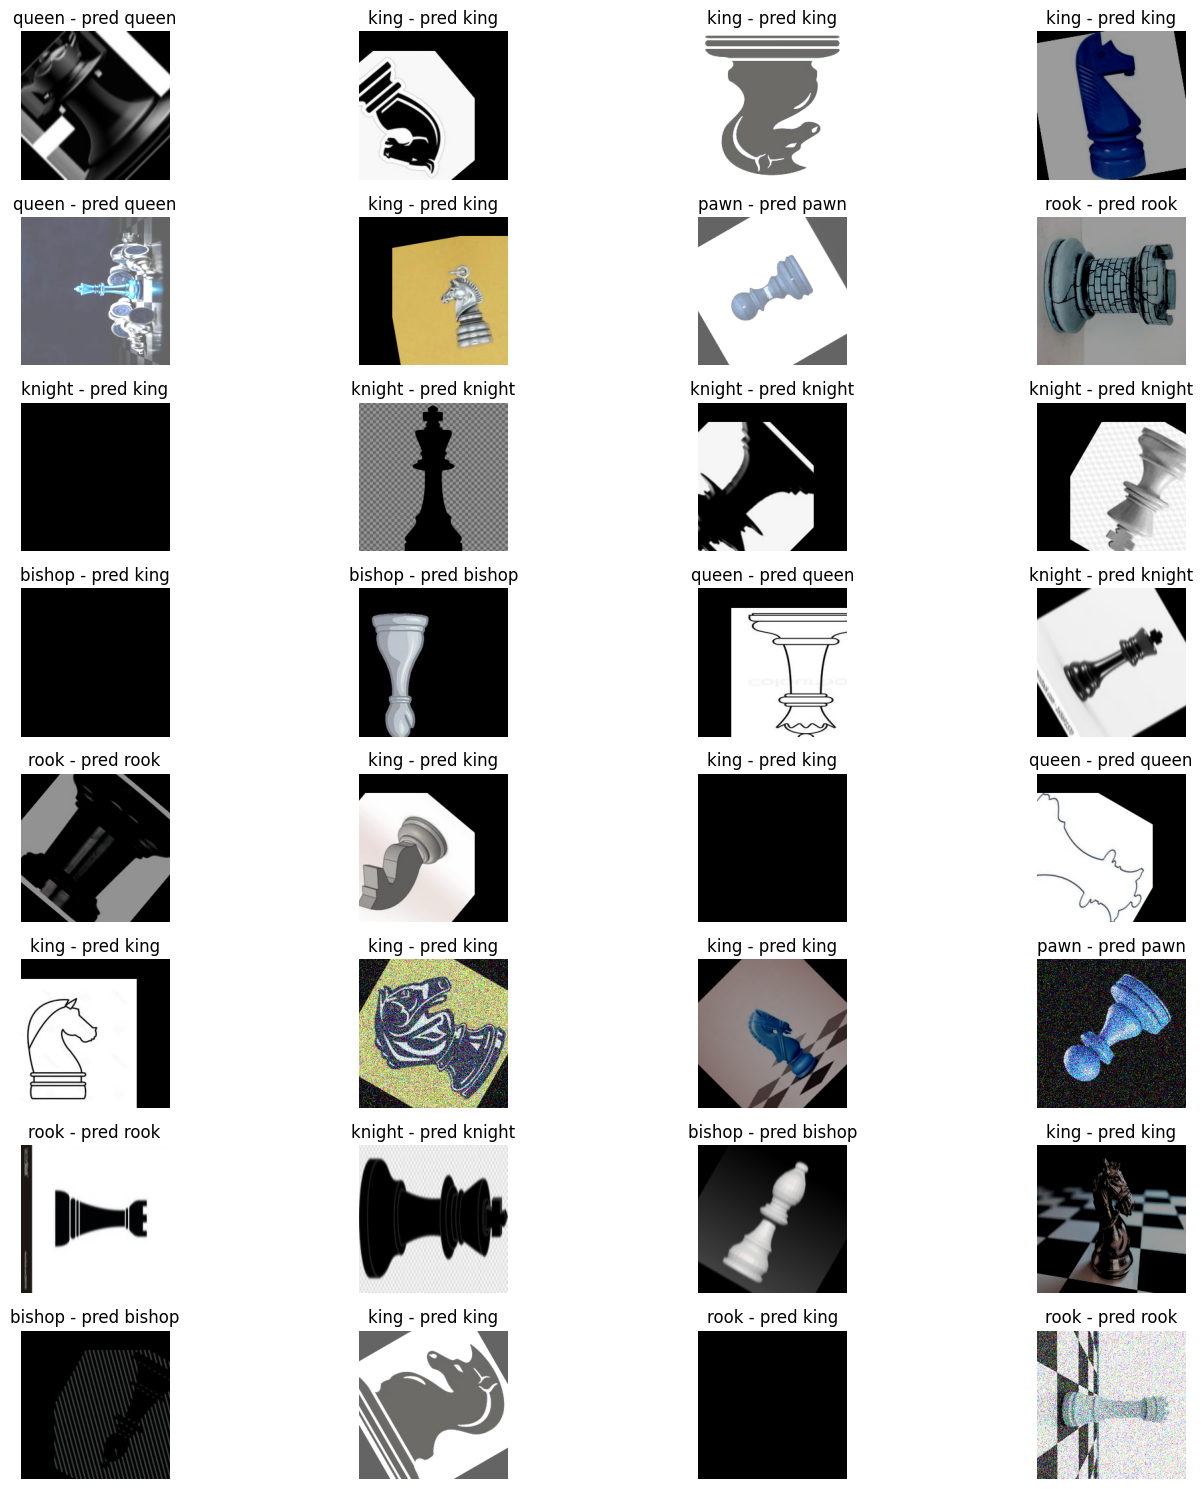

In [28]:
#Display 32 images in an 8x4 grid
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 8
c = 1
names = ['bishop', 'knight', 'king', 'pawn', 'queen', 'rook']

for i in range(len(labels)):
    fig.add_subplot(rows, columns, c)
    img = images[i].cpu()
    imshow(img, names[labels[i]], names[preds[i]])
    c += 1
plt.tight_layout()
plt.show()

### Further steps that can improve classification performance
* Classifier network was trained for 5 epochs and validation loss decreased in every epoch. Training for more epochs will definitely result in better performance.
* In order to decrease the training time, a simpler network or less data can be trained for more epochs.
* Image augmentation can be altered after an analysis of incorrectly classifier images in validation set. 